# Literature Review Program with Python and Topic Modeling

<p>Program to develop a literature exploratory analysis from articles with Latent Dirichlet Allocation (LDA) algorithm.</p>
<p>The database contains the following characteristic:</p>

<ul>
  <li>Source: Web of Science & Scopus</li>
  <li>Range: 2003 to 2021/feb</li>
    <li>Articles: 694</li>
  <li>Variables:
    <ul>
      <li>AU: authors</li>
      <li>TI: title</li>
      <li>PY: publish year</li>
      <li>AB: abstract</li>
      <li>AB_Clean: abstract preprocessed</li>
      <li>DI: doi</li>
      <li>Country: first author affiliation </li>
      <li>Field: research field</li>
      <li>Subject: subject area</li>
      <li>Quartile: scientific journal rankings</li>
    </ul>
  </li>
  </ul>
  
**This program is divided into three sections:**
1. Reading database; 
2. Pre-processing corpus; 
3. Identify dominant topics.

**Reports:**

* Report01: coherence scores
* Report02: terms and topics 
* Report03: most important topics by article
* Report04: master corpus dataframe
* Report05: dominant topics and total docs
* Report06: relevant papers

**Benchmark(computer system):**
* Estimated processing time: 2h
* Processor: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz 2.90GHz
* RAM: 8,00 GB
* System: Windows 10 Home 64 bits

**Citation:**

[Santos, A.L.M.F](http://lattes.cnpq.br/1030756025619809); [Silva, J. E. P.](http://lattes.cnpq.br/5464670038922392); 
[Nunes,K.J.F.S.](http://lattes.cnpq.br/8701754979998018); [Silva,I.C.](http://lattes.cnpq.br/4922228816252524). (2021). Literature Review Program with Python and Topic Modeling. [DOI:10.5281/zenodo.4588060](https://github.com/andrelmfsantos/ISSN21772436/tree/v1.0.0)

# 1. Reading database

In [1]:
# Libraries required
# Need in the same folder "contractions.py"; "text_normalizer.py"; "model_evaluation_utils.py"

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib as plt
pd.options.display.max_colwidth - 200
%matplotlib inline
plt.style.use('fivethirtyeight')

import keras.backend as K
from keras.layers import Dense, Embedding, Lambda
from keras.layers import Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams
from keras.utils import np_utils
from keras.utils import plot_model

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import gutenberg

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import spacy
import text_normalizer as tn

import warnings
warnings.filterwarnings('ignore')

from string import punctuation
from tqdm import tqdm
from operator import itemgetter
from collections import Counter

import model_evaluation_utils as meu
import itertools
import gensim
import pickle
import seaborn as sns
import copy

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Dataset from Github

dataset = pd.read_csv('https://raw.githubusercontent.com/andrelmfsantos/ISSN21772436/main/dataset/openinnovation.csv', 
                      sep = ";")
print('Rows = ',len(dataset))
dataset.head(5)

Rows =  694


,AU,TI,PY,AB,AB_Clean,DI,UT,Country,Field,Subject,Quartile
0,"Papadopoulos T., Stamati T., Nikolaidou M., An...",From open source to open innovation practices:...,2013,"""Open"" practices have been at the forefront of...",Open practices have been at the forefront of r...,10.1016/j.techfore.2012.10.030,2-s2.0-84878350452,United Kingdom,"Business, Management and Accounting; Psychology",Social Sciences & Humanities,Q1
1,"Tirmizi S.M.A., Malik Q.A., Hussain S.S.","Invention and open innovation processes, and l...",2020,A conceptual model has been developed to prese...,A conceptual model has been developed to prese...,10.3390/joitmc6040159,2-s2.0-85096406255,Pakistan,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities,Q1
2,"Bianchi M., Campodall'Orto S., Frattini F., Ve...",Enabling open innovation in small- and medium-...,2010,A critical success factor in the practice of O...,A critical success factor in the practice of O...,10.1111/j.1467-9310.2010.00613.x,2-s2.0-77955977614,Italy,"Business, Management and Accounting",Social Sciences & Humanities,Q1
3,"Sarkar S., Costa A.I.A.",Dynamics of open innovation in the food industry,2008,"A growing number of chain actors, together wit...","A growing number of chain actors, together wit...",10.1016/j.tifs.2008.09.006,2-s2.0-55549101557,Portugal,Agricultural and Biological Sciences; Biochemi...,Life Sciences,Q1
4,"Yoon S., Jeong S.",Effects to implement the open-innovation coord...,2017,"A reverse supply chain, as a post-consumption ...","A reverse supply chain, as a post-consumption ...",10.1186/s40852-017-0054-3,2-s2.0-85033401124,South Korea,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities,Q1


In [3]:
# building a corpus of documents - pg.203

corpus = list(dataset['AB_Clean'])
labels = list(dataset['Subject'])

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,Open practices have been at the forefront of r...,Social Sciences & Humanities
1,A conceptual model has been developed to prese...,Social Sciences & Humanities
2,A critical success factor in the practice of O...,Social Sciences & Humanities
3,"A growing number of chain actors, together wit...",Life Sciences
4,"A reverse supply chain, as a post-consumption ...",Social Sciences & Humanities
...,...,...
689,While the research on Open Innovation is flour...,Social Sciences & Humanities
690,Wine Influencers (WIs) represent a new type of...,Social Sciences & Humanities
691,"With globalisation, there has been an intensif...",Social Sciences & Humanities
692,With increasingly severe environmental regulat...,Social Sciences & Humanities


# 2. Pre-processing corpus

In [4]:
# preprocessing our text corpus - pg.205

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [5]:
# apply it to our sample corpus - pg.207

norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['open practices forefront research business political agendas time traditionally research focused analysing critical factors deployment open source os software highlighted roles collective intelligence participation voluntary communities facilitating os development nevertheless little literature examining role open innovation practices may play influencing privatecollective model innovation application economiesincrisis create publicgood innovations address gap paper uses case greece data gathered interviews conducted public policy makers private sector top executives findings underline importance using os software deal cost reduction debt crisis importantly reveal shift os utilising aforementioned open innovation practices support creation publicgood innovations privatecollective model innovation difficulties faced encouraging initiative due insufficient national innovation policy different philosophies structures cultures followed organisations study calls changes national pol

In [7]:
# Bag of words models - pg.208

#from sklearn.feature_extraction.text import CountVectorizer

#get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<694x7865 sparse matrix of type '<class 'numpy.int64'>'
	with 55522 stored elements in Compressed Sparse Row format>

In [8]:
# view dense representation

# warining might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# 3. Identify dominant topics

In [9]:
# Document-topic feature matrix from our LDA model - pg.230

#from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=3, max_iter=10000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3'])
features

,T1,T2,T3
0,0.003039,0.003372,0.993590
1,0.002920,0.515257,0.481822
2,0.005336,0.413127,0.581537
3,0.005662,0.602502,0.391837
4,0.002571,0.002588,0.994841
...,...,...,...
689,0.004907,0.357240,0.637852
690,0.003936,0.133714,0.862350
691,0.002978,0.003131,0.993891
692,0.003081,0.993684,0.003235


In [10]:
# Loading the bible corpus - pg.233

#from nltk.corpus import gutenberg
#from string import punctuation

bible = corpus_df['Document']
bible =  [i.split(' ') for i in bible]
remove_terms = punctuation + '0123456789'
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]
print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 694

Sample line: ['Accounts', 'of', 'open', 'source', 'software', '(OSS)', 'development', 'projects', 'frequently', 'stress', 'their', 'democratic,', 'sometimes', 'even', 'anarchic', 'nature,', 'in', 'contrast', 'to', 'for-profit', 'organisations.', 'Given', 'this', 'observation,', 'our', 'research', 'evaluates', 'qualitative', 'data', 'from', 'Wikipedia,', 'a', 'free', 'online', 'encyclopaedia', 'whose', 'development', 'mechanism', 'allegedly', 'resembles', 'that', 'of', 'OSS', 'projects.', 'Our', 'research', 'offers', 'contributions', 'to', 'the', 'field', 'of', 'Open', 'Innovation', 'research', 'with', 'three', 'major', 'findings.', 'First,', 'we', 'shed', 'light', 'on', 'Wikipedia', 'as', 'a', 'phenomenon', 'that', 'has', 'received', 'scant', 'attention', 'from', 'management', 'scholars', 'to', 'date.', 'Second,', 'we', 'show', 'that', 'OSS-related', 'motivational', 'mechanisms', 'partially', 'apply', 'to', 'Wikipedia', 'participants.', 'Third,', 'our', 'exploration',

In [11]:
# Implementing the Continuous Bag of Words (CBOW) Model - pg.236
# build the corpus vocabulary

#from keras.preprocessing import text
#from keras.utils import np_utils
#from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 7880
Vocabulary Sample: [('innovation', 1), ('open', 2), ('firms', 3), ('research', 4), ('knowledge', 5), ('study', 6), ('paper', 7), ('oi', 8), ('performance', 9), ('external', 10)]


In [12]:
# Build a CBOW (Context, Target) Generator - pg.237

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index])
            label_word.append(word)
            
            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        if i == 10:
            break
        i += 1

Context (X): ['open', 'practices', 'research', 'business'] -> Target (Y): forefront
Context (X): ['practices', 'forefront', 'business', 'political'] -> Target (Y): research
Context (X): ['forefront', 'research', 'political', 'agendas'] -> Target (Y): business
Context (X): ['research', 'business', 'agendas', 'time'] -> Target (Y): political
Context (X): ['business', 'political', 'time', 'traditionally'] -> Target (Y): agendas
Context (X): ['political', 'agendas', 'traditionally', 'research'] -> Target (Y): time
Context (X): ['agendas', 'time', 'research', 'focused'] -> Target (Y): traditionally
Context (X): ['time', 'traditionally', 'focused', 'analysing'] -> Target (Y): research
Context (X): ['traditionally', 'research', 'analysing', 'critical'] -> Target (Y): focused
Context (X): ['research', 'focused', 'critical', 'factors'] -> Target (Y): analysing
Context (X): ['focused', 'analysing', 'factors', 'deployment'] -> Target (Y): critical


In [13]:
# CBOW model summary and architecture - pg.239

#import keras.backend as K
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, Lambda
#from keras.utils import plot_model

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

#view model summary
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            788000    
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 7880)              795880    
Total params: 1,583,880
Trainable params: 1,583,880
Non-trainable params: 0
_________________________________________________________________
None


### The Skip-Gram Model - pg 244

In [14]:
# Implementing the Skip-Gram Model - pg.246
# Build the Corpus Vocabulary

#from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 7880
Vocabulary Sample: [('innovation', 1), ('open', 2), ('firms', 3), ('research', 4), ('knowledge', 5), ('study', 6), ('paper', 7), ('oi', 8), ('performance', 9), ('external', 10)]


In [15]:
# Build a Skip-Gram [(target, context), relevancy] Generator - pg.247

#from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10)
for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(id2word[pairs[i][0]], pairs[i][0],
                                                      id2word[pairs[i][1]], pairs[i][1],
                                                      labels[i]))

(open (2), factors (77)) -> 1
(model (14), internetbased (5795)) -> 0
(privatecollective (2867), model (14)) -> 1
(software (194), political (1331)) -> 0
(private (534), wire (6559)) -> 0
(national (317), steps (2176)) -> 0
(innovation (1), encourages (3117)) -> 0
(uses (467), case (35)) -> 1
(practices (25), shift (656)) -> 1
(analysing (1154), critical (274)) -> 1


In [16]:
# Build the Skip-Gram Model Architecture - pg.248

#from keras.layers import Dot
#from keras.layers.core import Dense, Reshape
#from keras.layers.embeddings import Embedding
#from keras.models import Sequential
#from keras.models import Model

# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform", input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform", input_length=1))
context_model.add(Reshape((embed_size,)))
model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(model_arch)
model = Model([word_model.input,context_model.input], model_arch)
model.compile(loss="mean_squared_error", optimizer="rmsprop")

# view model summary
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       788000      embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       788000      embedding_2_input[0][0]          
_______________________________________________________________________________________

In [17]:
# Train the Model - pg.251

for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)
    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 146.5488125011325
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 115.28746635466814
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 108.33040361851454
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 104.65712377429008
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 102.09680123627186


In [18]:
# Word embeddings for our vocabulary based on the Skip-Gram model - pg.252

word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(7879, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
innovation,-0.084765,0.079237,0.068705,0.001508,0.080129,-0.003962,0.025255,0.000110,0.003207,-0.076509,...,-0.040082,-0.013264,0.043190,-0.015329,-0.009598,-0.010309,0.082271,0.001904,0.017041,0.072526
open,-0.063366,0.098464,-0.011623,0.029481,0.094723,-0.000214,-0.052168,0.013907,0.087057,-0.045932,...,-0.010499,-0.017377,-0.003985,0.008095,0.020610,-0.011704,0.040660,0.074339,0.058494,0.097459
firms,-0.035604,0.059076,0.050666,0.040841,0.007574,0.021287,-0.051664,-0.089450,-0.043112,-0.069803,...,-0.059138,-0.054915,-0.014072,-0.041823,-0.044553,0.009474,0.061617,0.013089,-0.047239,0.086327
research,-0.002420,0.013421,-0.039494,0.065166,0.034648,-0.008991,-0.039544,0.005962,0.072912,-0.001329,...,-0.054951,-0.010198,0.058567,-0.046968,0.034645,-0.063540,0.055990,-0.005634,0.065994,0.097996
knowledge,-0.028367,-0.004349,-0.024870,-0.016634,0.079517,0.026621,-0.055852,-0.027189,0.028017,-0.054269,...,-0.040668,-0.020152,0.008906,0.000787,0.021564,0.024137,0.017068,-0.062088,-0.008395,0.044340


In [19]:
# building the dataframe - pg.286

data_df = pd.DataFrame({'Article':dataset['AB_Clean'], 'TargetLabel':dataset['Field'], 'TargetName':dataset['Subject']})
print(data_df.shape)
data_df.head(10)

(694, 3)


,Article,TargetLabel,TargetName
0,Open practices have been at the forefront of r...,"Business, Management and Accounting; Psychology",Social Sciences & Humanities
1,A conceptual model has been developed to prese...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
2,A critical success factor in the practice of O...,"Business, Management and Accounting",Social Sciences & Humanities
3,"A growing number of chain actors, together wit...",Agricultural and Biological Sciences; Biochemi...,Life Sciences
4,"A reverse supply chain, as a post-consumption ...","Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
5,Each individual member of an organization must...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
6,Geographic research on firm-level innovation i...,"Business, Management and Accounting; Economics...",Social Sciences & Humanities
7,Academia–enterprise collaboration is understoo...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
8,Academics and practitioners have demonstrated ...,"Business, Management and Accounting; Psychology",Social Sciences & Humanities
9,According to the WHO Global Digital Health Str...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities


In [20]:
# Data Preprocessing and Normalization - pg.287

total_nulls = data_df[data_df.Article.str.strip() == ''].shape[0]
print("Empty documents:", total_nulls)

Empty documents: 0


In [21]:
# Remove all the records with no textual content in the article - pg.287

data_df = data_df[~(data_df.Article.str.strip() == '')]
data_df.shape

(694, 3)

In [22]:
# normalize our corpus - pg.290 (adapted from pg.203)

corpus = list(data_df['Article'])
corpus = np.array(corpus)
norm_corpus = normalize_corpus(corpus)
data_df['CleanArticle'] = norm_corpus

# view sample data

data_df = data_df[['Article', 'CleanArticle', 'TargetLabel', 'TargetName']]
data_df.head(10)

,Article,CleanArticle,TargetLabel,TargetName
0,Open practices have been at the forefront of r...,open practices forefront research business pol...,"Business, Management and Accounting; Psychology",Social Sciences & Humanities
1,A conceptual model has been developed to prese...,conceptual model developed present comprehensi...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
2,A critical success factor in the practice of O...,critical success factor practice open innovati...,"Business, Management and Accounting",Social Sciences & Humanities
3,"A growing number of chain actors, together wit...",growing number chain actors together difficult...,Agricultural and Biological Sciences; Biochemi...,Life Sciences
4,"A reverse supply chain, as a post-consumption ...",reverse supply chain postconsumption activity ...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
5,Each individual member of an organization must...,individual member organization must recognize ...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
6,Geographic research on firm-level innovation i...,geographic research firmlevel innovation gener...,"Business, Management and Accounting; Economics...",Social Sciences & Humanities
7,Academia–enterprise collaboration is understoo...,academiaenterprise collaboration understood de...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities
8,Academics and practitioners have demonstrated ...,academics practitioners demonstrated open inno...,"Business, Management and Accounting; Psychology",Social Sciences & Humanities
9,According to the WHO Global Digital Health Str...,according global digital health strategy advoc...,"Economics, Econometrics and Finance; Social Sc...",Social Sciences & Humanities


In [23]:
# Test if have some documents that, after preprocessing, might end up being empty or null - pg.291

data_df = data_df.replace(r'^(\s?)+$', np.nan, regex=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 0 to 693
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Article       694 non-null    object
 1   CleanArticle  694 non-null    object
 2   TargetLabel   694 non-null    object
 3   TargetName    694 non-null    object
dtypes: object(4)
memory usage: 27.1+ KB


In [24]:
# Remove null documents

data_df = data_df.dropna().reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Article       694 non-null    object
 1   CleanArticle  694 non-null    object
 2   TargetLabel   694 non-null    object
 3   TargetName    694 non-null    object
dtypes: object(4)
memory usage: 21.8+ KB


In [25]:
# Building Train and Test Datasets

#from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(data_df['CleanArticle']), np.array(data_df['TargetLabel']),
                                                       np.array(data_df['TargetName']), test_size=0.7, random_state=42)

train_corpus.shape, test_corpus.shape

((208,), (486,))

### TF-IDF Features with Classification Models - pg.319

In [26]:
# Performance models - pg.319

#from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)

# transform test articles into features
tv_test_features = tv.transform(test_corpus)

print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (208, 4400)  Test features shape: (486, 4400)


### Topic Modeling - pg.362

In [27]:
papers = data_df.Article
print(papers)

0      Open practices have been at the forefront of r...
1      A conceptual model has been developed to prese...
2      A critical success factor in the practice of O...
3      A growing number of chain actors, together wit...
4      A reverse supply chain, as a post-consumption ...
                             ...                        
689    While the research on Open Innovation is flour...
690    Wine Influencers (WIs) represent a new type of...
691    With globalisation, there has been an intensif...
692    With increasingly severe environmental regulat...
693    With its focus on value creation and value cap...
Name: Article, Length: 694, dtype: object


In [28]:
%%time
#import nltk

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

694
Wall time: 5.25 s


In [29]:
norm_papers = normalize_corpus(corpus)
print(norm_papers[0][:512])

['open', 'practice', 'forefront', 'research', 'business', 'political', 'agenda', 'time', 'traditionally', 'research', 'ha', 'focused', 'analysing', 'critical', 'factor', 'deployment', 'open', 'source', 'software', 'ha', 'highlighted', 'role', 'collective', 'intelligence', 'participation', 'voluntary', 'community', 'facilitating', 'development', 'nevertheless', 'little', 'literature', 'examining', 'role', 'open', 'innovation', 'practice', 'may', 'play', 'influencing', 'private', 'collective', 'model', 'innovation', 'application', 'economy', 'crisis', 'create', 'public', 'good', 'innovation', 'address', 'gap', 'paper', 'us', 'case', 'greece', 'data', 'gathered', 'interview', 'conducted', 'public', 'policy', 'maker', 'private', 'sector', 'top', 'executive', 'finding', 'underline', 'importance', 'using', 'software', 'deal', 'cost', 'reduction', 'debt', 'crisis', 'importantly', 'reveal', 'shift', 'utilising', 'aforementioned', 'open', 'innovation', 'practice', 'support', 'creation', 'public

In [30]:
# Topic Models with Gensim - pg.368

#import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=5, threshold=100, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)
# sample demonstration
print(bigram_model[norm_papers[0]][:50])

['open', 'practice', 'forefront', 'research', 'business', 'political', 'agenda', 'time', 'traditionally', 'research', 'ha', 'focused', 'analysing', 'critical', 'factor', 'deployment', 'open', 'source', 'software', 'ha', 'highlighted', 'role', 'collective', 'intelligence', 'participation', 'voluntary', 'community', 'facilitating', 'development', 'nevertheless', 'little', 'literature', 'examining', 'role', 'open', 'innovation', 'practice', 'may', 'play', 'influencing', 'private', 'collective', 'model', 'innovation', 'application', 'economy', 'crisis', 'create', 'public', 'good']


In [31]:
# Let’s generate phrases for all our tokenized research papers and build a vocabulary - pg.370

norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'address'), (1, 'aforementioned'), (2, 'agenda'), (3, 'analysing'), (4, 'application'), (5, 'business'), (6, 'call'), (7, 'case'), (8, 'change'), (9, 'collective'), (10, 'community'), (11, 'conducted'), (12, 'cost'), (13, 'create'), (14, 'creation')]
Total Vocabulary Size: 6399


In [32]:
# Prune our vocabulary and start removing terms - pg.370
# Github Ch06b - Topic Modeling with gensim.ipynb

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 606


In [33]:
# # Transforming corpus into bag of words vectors - pg.371
# Github Ch06b - Topic Modeling with gensim.ipynb

bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(22, 1), (26, 1), (29, 3), (38, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 5), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 5), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2)]


In [34]:
# viewing actual terms and their counts - pg.371

print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('ha', 1), ('literature', 1), ('model', 3), ('private', 1), ('access', 1), ('activity', 1), ('capacity', 1), ('collaboration', 1), ('complex', 1), ('conceptual', 3), ('country', 1), ('design', 1), ('developed', 1), ('develops', 1), ('digital', 1), ('dimension', 1), ('discussed', 1), ('existing', 1), ('firm', 1), ('first', 1), ('framework', 2), ('global', 1), ('idea', 2), ('including', 1), ('intellectual_property', 1), ('knowledge', 5), ('mechanism', 1), ('methodology', 1), ('new', 2), ('number', 1), ('organization', 1), ('patent', 1), ('phase', 2), ('present', 1), ('process', 5), ('product', 2), ('production', 1), ('provides', 1), ('second', 1), ('service', 1), ('skill', 1), ('social', 1), ('technological', 1), ('technology', 1), ('two', 1), ('university', 1), ('well', 1), ('world', 2)]


In [35]:
# total papers in the corpus - pg.371

print('Total number of papers:', len(bow_corpus))

Total number of papers: 694


### LDA Tuning: Finding the Optimal Number of Topics - pg.402

In [36]:
# LDA Tuning: Finding the Optimal Number of Topics - pg.402

#from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                           alpha='auto', eta='auto', random_state=42,
                                           iterations=500, num_topics=30, 
                                           passes=20, eval_every=None)
        cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                              texts=texts, dictionary=dictionary, 
                                                              coherence='c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(lda_model)
    
    return models, coherence_scores

In [37]:
# Finding the optimal number of topics in a topic model - part 1

#from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary,
                          start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        gensim_lda_model = gensim.models.LdaModel(
                                              corpus=corpus,
                                              num_topics=topic_nums,
                                              id2word=dictionary,
                                              chunksize=1740,
                                              iterations=500,
                                              alpha="auto",
                                              eta="auto",
                                              passes=20
                                                )

        cv_coherence_model_gensim_lda = gensim.models.CoherenceModel(model=gensim_lda_model,
                                                    corpus=corpus,
                                                    texts=texts,
                                                    dictionary=dictionary,
                                                    coherence='c_v')

        coherence_score = cv_coherence_model_gensim_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(gensim_lda_model)
        
        ### saving each model
        gensim_lda_model.save(''+str(topic_nums)+'.gensim')

    return models, coherence_scores

In [38]:
# Finding the optimal number of topics in a topic model - part 2


lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus,
                                                texts=norm_corpus_bigrams,
                                                dictionary=dictionary,
                                                start_topic_count=2,
                                                end_topic_count=30, step=1, cpus=16)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [31:37<00:00, 65.43s/it]


In [39]:
# Finding the optimal number of topics in a topic model - part 3

coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                        'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
5,7,0.3330
6,8,0.3323
11,13,0.3273
12,14,0.3263
3,5,0.3220
4,6,0.3215
14,16,0.3195
2,4,0.3150
13,15,0.3128
0,2,0.3121


In [40]:
#------------------------------------------------------------------------
# Report 1 - save coherence score df and coherence score list 

coherence_df.to_csv('Report01_coherence_df.csv', index=False)
#------------------------------------------------------------------------

In [41]:
# Finding the optimal number of topics in a topic model - part 4

#import pickle
with open("coherence_scores.txt", "wb") as fp:   #Pickling
    pickle.dump(coherence_scores, fp)

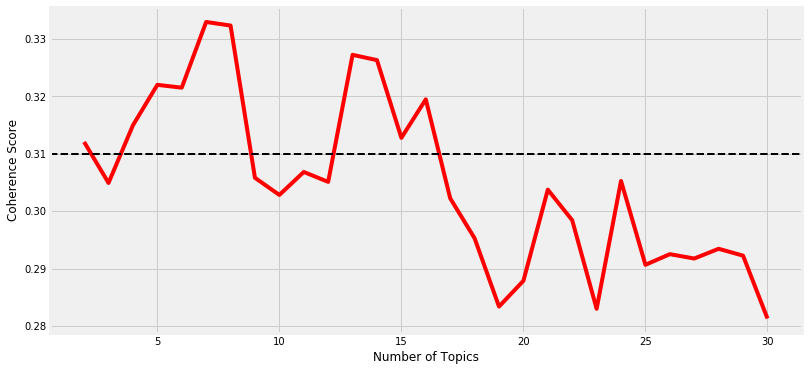

In [42]:
# Topic model tuning the number of topics vs. coherence score - pg.404

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=round(np.mean(coherence_scores),2), c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

In [43]:
# We can retrieve the best model - pg.405

best_model_idx = coherence_df[coherence_df['Number of Topics'] == 6].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

6

In [44]:
# Let’s view all the 20 topics generated by our selected best model - pg.405

topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['performance', 'firm', 'effect', 'network', 'smes', 'relationship', 'external', 'project', 'result', 'positive', 'study', 'product', 'organizational', 'impact', 'paper', 'model', 'data', 'influence', 'positively', 'show']

Topic #2:
['oi', 'research', 'study', 'firm', 'capability', 'paper', 'knowledge', 'approach', 'process', 'practice', 'purpose', 'finding', 'performance', 'result', 'analysis', 'management', 'relationship', 'based', 'literature', 'design_methodology']

Topic #3:
['technology', 'firm', 'collaboration', 'industry', 'patent', 'study', 'knowledge', 'university', 'research', 'technological', 'ha', 'external', 'strategy', 'activity', 'partner', 'policy', 'based', 'result', 'paper', 'value']

Topic #4:
['research', 'process', 'new', 'company', 'model', 'development', 'ha', 'case', 'paper', 'industry', 'challenge', 'study', 'organization', 'system', 'wa', 'based', 'technology', 'management', 'approach', 'network']

Topic #5:
['knowledge', 'firm', 'external', 'study

In [45]:
# A better way of visualizing the topics is to build a term-topic dataframe - 407

topics_df = pd.DataFrame([[term for term, wt in topic] 
                              for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Term1,performance,oi,technology,research,knowledge,social
Term2,firm,research,firm,process,firm,study
Term3,effect,study,collaboration,new,external,business
Term4,network,firm,industry,company,study,model
Term5,smes,capability,patent,model,source,idea
Term6,relationship,paper,study,development,search,service
Term7,external,knowledge,knowledge,ha,research,research
Term8,project,approach,university,case,absorptive_capacity,platform
Term9,result,process,research,paper,ha,market
Term10,positive,practice,technological,industry,finding,based


In [46]:
#------------------------------------------------------------------------
# Report 2 - terms and topics

topics_df.to_csv("Report02_TermsTopics.csv")
#------------------------------------------------------------------------

In [47]:
# Viewing all the topics of our LDA topic model - pg.408

topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

,Terms per Topic
Topic1,"performance, firm, effect, network, smes, rela..."
Topic2,"oi, research, study, firm, capability, paper, ..."
Topic3,"technology, firm, collaboration, industry, pat..."
Topic4,"research, process, new, company, model, develo..."
Topic5,"knowledge, firm, external, study, source, sear..."
Topic6,"social, study, business, model, idea, service,..."


### Latent Semantic Indexing - pg.372

In [48]:
%%time

TOTAL_TOPICS = best_lda_model.num_topics
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

Wall time: 10.3 s


In [49]:
# major topics or themes in our corpus - pg.372

for topic_id, topic in lsi_bow.print_topics(num_topics=TOTAL_TOPICS, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.384*"firm" + 0.267*"knowledge" + 0.239*"study" + 0.236*"research" + 0.205*"oi" + 0.172*"performance" + 0.163*"paper" + 0.148*"technology" + 0.143*"process" + 0.135*"external" + 0.128*"model" + 0.123*"result" + 0.115*"based" + 0.115*"finding" + 0.111*"approach" + 0.111*"ha" + 0.109*"relationship" + 0.107*"new" + 0.106*"effect" + 0.103*"capability"

Topic #2:
0.726*"firm" + -0.264*"oi" + -0.238*"research" + 0.163*"performance" + 0.155*"technology" + -0.146*"model" + 0.140*"external" + -0.125*"process" + -0.116*"company" + -0.111*"paper" + -0.100*"management" + -0.097*"approach" + -0.083*"based" + -0.083*"analysis" + -0.080*"development" + -0.074*"organization" + -0.071*"public" + -0.068*"case" + -0.065*"author" + -0.063*"project"

Topic #3:
0.800*"oi" + -0.201*"knowledge" + 0.167*"capability" + 0.145*"performance" + -0.139*"technology" + -0.128*"process" + 0.104*"firm" + -0.104*"idea" + -0.099*"research" + -0.092*"ha" + -0.090*"new" + -0.087*"social" + 0.087*"practice" + -0.0

In [50]:
# Separate different sub-themes based on the sign or orientation of terms - pg.375

for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('firm', 0.384), ('knowledge', 0.267), ('study', 0.239), ('research', 0.236), ('oi', 0.205), ('performance', 0.172), ('paper', 0.163), ('technology', 0.148), ('process', 0.143), ('external', 0.135), ('model', 0.128), ('result', 0.123), ('based', 0.115), ('finding', 0.115), ('approach', 0.111), ('ha', 0.111), ('relationship', 0.109), ('new', 0.107), ('effect', 0.106), ('capability', 0.103)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('firm', 0.726), ('performance', 0.163), ('technology', 0.155), ('external', 0.14)]
--------------------------------------------------
Direction 2: [('oi', -0.264), ('research', -0.238), ('model', -0.146), ('process', -0.125), ('company', -0.116), ('paper', -0.111), ('management', -0.1), ('approach', -0.097), ('based', -0.083), ('analysis', -0.083), ('development', -0.08), ('organization', -0.074), ('public', -0.071), ('case', -0.068), 

In [51]:
# SVD - pg.379

term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

((606, 6), (6,), (6, 694))

In [52]:
# Output shows - pg.379

document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6
0,0.026,-0.040,-0.023,-0.028,0.013,-0.026
1,0.035,-0.015,-0.052,0.050,0.030,0.024
2,0.021,0.016,-0.010,-0.006,0.019,0.020
3,0.018,-0.007,-0.015,0.000,0.000,0.028
4,0.022,-0.016,-0.009,-0.022,-0.002,-0.004
5,0.028,-0.022,-0.004,-0.007,-0.051,-0.009
6,0.021,0.020,-0.010,-0.011,0.004,-0.013
7,0.024,-0.022,-0.016,0.020,-0.009,-0.008
8,0.041,0.070,-0.007,0.008,-0.024,0.069
9,0.034,-0.044,-0.038,-0.018,0.015,-0.004


In [53]:
# Find out the most important topics for a few sample papers - pg.380

document_numbers = range(0,9)

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #0:
Dominant Topics (top 3): ['T2', 'T4', 'T1']
Paper Summary:
Open practices have been at the forefront of research, business and political agendas for some time. Traditionally, research has focused on analysing critical factors for the deployment of Open Source (OS) Software and has highlighted the roles of "Collective Intelligence" and "participation in voluntary communities" in facilitating OS development. Nevertheless, there is little literature examining the role these Open Innovation practices may play in influencing the private-collective model of i

Document #1:
Dominant Topics (top 3): ['T3', 'T4', 'T1']
Paper Summary:
A conceptual model has been developed to present comprehensively the processes and linkages of invention and Open Innovation for those knowledge workers who want to transform idea of a new product or service into a reality. The progression of idea conceptualization, realization and marketing is further divided into two phases; first is invention and se

In [54]:
#------------------------------------------------------------------------
# Report 3 - most important topics by article
import_topics = pd.concat([corpus_df, document_topics], axis=1)
import_topics.to_csv("Report03_MostImportantTopics.csv")
import_topics
#------------------------------------------------------------------------

,Document,Category,T1,T2,T3,T4,T5,T6
0,Open practices have been at the forefront of r...,Social Sciences & Humanities,0.026,-0.040,-0.023,-0.028,0.013,-0.026
1,A conceptual model has been developed to prese...,Social Sciences & Humanities,0.035,-0.015,-0.052,0.050,0.030,0.024
2,A critical success factor in the practice of O...,Social Sciences & Humanities,0.021,0.016,-0.010,-0.006,0.019,0.020
3,"A growing number of chain actors, together wit...",Life Sciences,0.018,-0.007,-0.015,0.000,0.000,0.028
4,"A reverse supply chain, as a post-consumption ...",Social Sciences & Humanities,0.022,-0.016,-0.009,-0.022,-0.002,-0.004
...,...,...,...,...,...,...,...,...
689,While the research on Open Innovation is flour...,Social Sciences & Humanities,0.016,-0.012,-0.018,-0.007,-0.004,-0.002
690,Wine Influencers (WIs) represent a new type of...,Social Sciences & Humanities,0.029,-0.020,-0.015,-0.034,-0.024,-0.019
691,"With globalisation, there has been an intensif...",Social Sciences & Humanities,0.027,-0.029,-0.024,-0.007,-0.010,0.002
692,With increasingly severe environmental regulat...,Social Sciences & Humanities,0.036,0.048,-0.013,-0.036,-0.002,0.121


### Interpreting Topic Model Results - pg.409

In [55]:
# Predict the distribution of topics in each research paper - pg.409

tm_results = best_lda_model[bow_corpus]

In [56]:
# Most dominant topic per research paper with some intelligent sorting and indexing - pg.410

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]
corpus_topics[:5]

[(3, 0.9964248),
 (2, 0.55703646),
 (5, 0.3653786),
 (3, 0.46348214),
 (3, 0.99661714)]

In [57]:
# Master dataframe that will hold the base statistics - pg.410

corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(corpus_topics))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = corpus_df.Document
corpus_topic_df = pd.concat([corpus_topic_df,dataset.DI],axis=1)
corpus_topic_df

,Document,Dominant Topic,Contribution %,Topic Desc,Paper,DI
0,0,4,99.64,"research, process, new, company, model, develo...",Open practices have been at the forefront of r...,10.1016/j.techfore.2012.10.030
1,1,3,55.70,"technology, firm, collaboration, industry, pat...",A conceptual model has been developed to prese...,10.3390/joitmc6040159
2,2,6,36.54,"social, study, business, model, idea, service,...",A critical success factor in the practice of O...,10.1111/j.1467-9310.2010.00613.x
3,3,4,46.35,"research, process, new, company, model, develo...","A growing number of chain actors, together wit...",10.1016/j.tifs.2008.09.006
4,4,4,99.66,"research, process, new, company, model, develo...","A reverse supply chain, as a post-consumption ...",10.1186/s40852-017-0054-3
...,...,...,...,...,...,...
689,689,1,59.57,"performance, firm, effect, network, smes, rela...",While the research on Open Innovation is flour...,10.1111/radm.12355
690,690,6,52.76,"social, study, business, model, idea, service,...",Wine Influencers (WIs) represent a new type of...,10.3390/joitmc6040165
691,691,4,87.68,"research, process, new, company, model, develo...","With globalisation, there has been an intensif...",10.3390/joitmc7010051
692,692,3,43.96,"technology, firm, collaboration, industry, pat...",With increasingly severe environmental regulat...,10.1002/bse.1974


In [58]:
#------------------------------------------------------------------------
# Report 4 - master corpus dataframe
corpus_topic_df.to_csv("Report04_Master_Corpus_Topic.csv")
#------------------------------------------------------------------------

### Dominant Topics Distribution Across Corpus - pg.410

In [59]:
# Viewing the distribution of dominant topics - pg.410

pd.set_option('display.max_colwidth', 100)

topic_stats_df = pd.DataFrame(corpus_topic_df['Dominant Topic'],columns=['Dominant Topic'])
topic_stats_df['Doc Count'] = topic_stats_df.groupby(by='Dominant Topic')['Dominant Topic'].transform('count')
topic_stats_df['% Total Docs'] = round(topic_stats_df['Doc Count']/len(corpus_topic_df)*100,2)
paper_df = corpus_topic_df[['Dominant Topic','Topic Desc']]
topic_stats_df = pd.merge(topic_stats_df,paper_df, on="Dominant Topic", how='inner')
topic_stats_df = topic_stats_df.drop_duplicates(subset=['Dominant Topic'])
topic_stats_df = topic_stats_df.sort_values(by=['Dominant Topic'], ascending=True)
topic_stats_df = topic_stats_df.reset_index(drop=True)
topic_stats_df

,Dominant Topic,Doc Count,% Total Docs,Topic Desc
0,1,93,13.40,"performance, firm, effect, network, smes, relationship, external, project, result, positive, stu..."
1,2,145,20.89,"oi, research, study, firm, capability, paper, knowledge, approach, process, practice, purpose, f..."
2,3,84,12.10,"technology, firm, collaboration, industry, patent, study, knowledge, university, research, techn..."
3,4,224,32.28,"research, process, new, company, model, development, ha, case, paper, industry, challenge, study..."
4,5,83,11.96,"knowledge, firm, external, study, source, search, research, absorptive_capacity, ha, finding, pr..."
5,6,65,9.37,"social, study, business, model, idea, service, research, platform, market, based, ecosystem, eco..."


In [63]:
#------------------------------------------------------------------------
# Report 5 - dominant topics and total docs
topic_stats_df.to_csv("Report05_DominantTopic-ToTalDocs.csv")
#------------------------------------------------------------------------

### Relevant Research Papers per Topic Based on Dominance - pg.413

In [61]:
# Viewing each topic and corresponding paper with its maximum contribution - pg.413

relevant_papers_df = corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set:
                                                                     (topic_set.sort_values(by=['Contribution %'],
                                                                                            ascending=False).iloc[0]))
relevant_papers_df

,Document,Dominant Topic,Contribution %,Topic Desc,Paper,DI
Dominant Topic,,,,,,
1,313,1,99.70,"performance, firm, effect, network, smes, relationship, external, project, result, positive, stu...",Purpose: Innovation projects are often risky and costly. But not all innovation projects lead to...,10.1108/BPMJ-04-2016-0076
2,342,2,99.85,"oi, research, study, firm, capability, paper, knowledge, approach, process, practice, purpose, f...",Purpose: The purpose of this paper is to fill a significant research gap in academic literature ...,10.1108/JKM-02-2020-0122
3,530,3,99.70,"technology, firm, collaboration, industry, patent, study, knowledge, university, research, techn...",The success of Open Innovation as a new paradigm to enhance innovation development has brought p...,10.1016/j.techfore.2017.02.022
4,9,4,99.78,"research, process, new, company, model, development, ha, case, paper, industry, challenge, study...","According to the WHO Global Digital Health Strategy 2020-2024, we should advocate people-centred...",10.3390/JOITMC6020039
5,163,5,99.77,"knowledge, firm, external, study, source, search, research, absorptive_capacity, ha, finding, pr...",Integrating insights from the strategic goal literature and the knowledge-based view of the firm...,10.1111/jpim.12511
6,316,6,99.75,"social, study, business, model, idea, service, research, platform, market, based, ecosystem, eco...",Purpose: Nurses are well-positioned to play an active role in the development of innovation in h...,10.1111/jnu.12559


In [62]:
#------------------------------------------------------------------------
# Report 6 - relevant papers
relevant_papers_df.to_csv("Report06_RelevantPapers.csv")
#------------------------------------------------------------------------

### Reference
* Sarkar, D. (2019). Text Analytics with Python. Apress. doi:10.1007/978-1-4842-4354-1